In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

In [4]:
processor = AutoProcessor.from_pretrained("bookbot/lightspeech-mfa-en-v6")
processor.mode = "eval"

/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [15]:
input_text = "hello from tensorflow tee tee s in see plus plus"
input_ids = processor.text_to_sequence(input_text)

In [16]:
input_ids

[8,
 31,
 12,
 43,
 7,
 34,
 53,
 13,
 18,
 50,
 14,
 17,
 30,
 7,
 12,
 15,
 18,
 42,
 18,
 42,
 50,
 17,
 51,
 14,
 17,
 42,
 16,
 12,
 53,
 17,
 16,
 12,
 53,
 17]

In [7]:
fastspeech2 = TFAutoModel.from_pretrained("bookbot/lightspeech-mfa-en-v6")

/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
2023-05-29 18:05:56.724612: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Save to Pb

In [5]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(fastspeech2, "./test_saved", signatures=fastspeech2.inference)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./test_saved/assets


# Load and Inference

In [6]:
fastspeech2 = tf.saved_model.load("./test_saved")

In [7]:
input_text = "There’s a way to measure the acute emotional intelligence that has never gone out of style."
input_ids = processor.text_to_sequence(input_text)

In [10]:
mel, duration_outputs, *_ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

In [11]:
mel

<tf.Tensor: shape=(1, 115, 80), dtype=float32, numpy=
array([[[-0.03922462, -0.05593672, -0.16052356, ..., -0.3431063 ,
         -0.42020977, -0.52046996],
        [ 0.31881428,  0.3127036 ,  0.21264555, ...,  0.01169705,
         -0.10307209, -0.24999511],
        [ 0.49705404,  0.46404967,  0.33012593, ...,  0.2413994 ,
          0.10304194, -0.08256976],
        ...,
        [-0.44696653, -0.6038221 , -0.75004596, ..., -0.78374565,
         -0.81336236, -0.84857315],
        [-0.4085325 , -0.5435601 , -0.68238395, ..., -0.8403435 ,
         -0.8714115 , -0.91491425],
        [-0.4806722 , -0.5939718 , -0.7201347 , ..., -0.91494375,
         -0.94733536, -0.9924281 ]]], dtype=float32)>

In [13]:
duration_outputs

<tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[10,  9,  9,  7,  6,  4, 12,  9,  9, 11, 18, 11]], dtype=int32)>

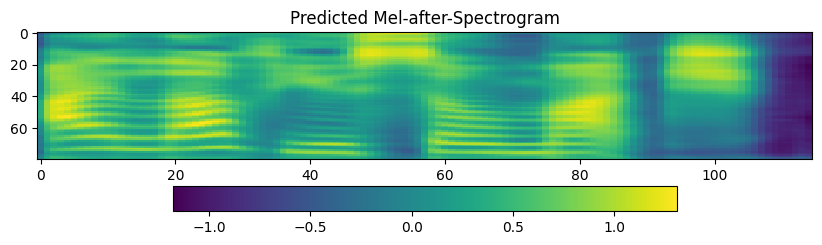

In [14]:
mel_after = tf.reshape(mel, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

# Let inference other input to check dynamic shape

In [10]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)

In [11]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

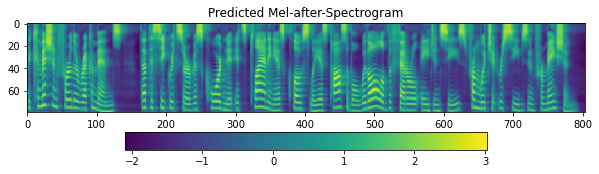

In [12]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()